In [1]:
!pip install opencv-python numpy open3d
!pip install timm
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.10
    Uninstalling jupyterlab_widgets-3.0.10:
      Successfully uninstalled jupyterlab_widgets-3.0.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets

In [2]:
import open3d as o3d
import numpy as np
import cv2

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


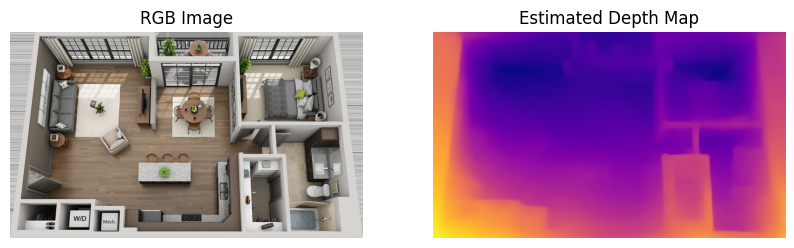

In [88]:
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt

# Load the MiDaS model
model = torch.hub.load("intel-isl/MiDaS", "MiDaS")
model.eval()

# Load transforms to resize and normalize the image
transform = torch.hub.load("intel-isl/MiDaS", "transforms").default_transform

# Load the RGB image
rgb_image = cv2.imread("1_3dplans_standard-3d-floor-plan.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Apply the transform to the image
input_image = transform(rgb_image).unsqueeze(0)

# Perform depth estimation
with torch.no_grad():
    depth_map = model((input_image.squeeze(0)))

# Convert depth map to numpy array and normalize for visualization
depth_map = depth_map.squeeze().cpu().numpy()
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Display the original image and the estimated depth map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("RGB Image")
plt.imshow(rgb_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Estimated Depth Map")
plt.imshow(depth_map, cmap='plasma')
plt.axis("off")

plt.show()

In [119]:
# Ensure the depth image is in the right format
if depth_map.dtype != np.float32:
    depth_map = depth_map.astype(np.float32)

import numpy as np
import cv2


def depth_to_point_cloud(depth_map, intrinsic_matrix):
    """
    Converts a depth map to a 3D point cloud.

    :param depth_map: 2D array where each value represents depth at that pixel
    :param intrinsic_matrix: 3x3 camera intrinsic matrix
    :return: Nx3 array of 3D points
    """
    # Get the shape of the depth map
    h, w = depth_map.shape

    # Create a mesh grid of pixel coordinates
    i, j = np.meshgrid(np.arange(w), np.arange(h), indexing='xy')

    # Reshape the pixel coordinates into a list of points
    pixels = np.stack([i, j, np.ones_like(i)], axis=-1).reshape(-1, 3)

    # Invert the intrinsic matrix
    intrinsic_inv = np.linalg.inv(intrinsic_matrix)

    # Compute the normalized coordinates in the camera frame
    normalized_coords = pixels @ intrinsic_inv.T

    # Multiply by the depth map to get the 3D coordinates
    depths = depth_map.flatten()
    points_3d = normalized_coords * depths[:, np.newaxis]

    return points_3d

# intrinsic_matrix = np.array([
#         [525.0, 0.0, 319.5],
#         [0.0, 525.0, 239.5],
#         [0.0, 0.0, 1.0]
#     ])
intrinsic_matrix = np.array([
    [500.0, 0.0, 320.0],
    [0.0, 500.0, 240.0],
    [0.0, 0.0, 1.0]
])
# Convert depth map to 3D point cloud
point_cloud = depth_to_point_cloud(depth_map, intrinsic_matrix)
point_cloud

array([[-0.41549271, -0.31161953,  0.64920735],
       [-0.40867783, -0.30746922,  0.64056087],
       [-0.4043677 , -0.30518317,  0.63579828],
       ...,
       [ 0.10131349, -0.02823491,  0.83043844],
       [ 0.10245392, -0.0280922 ,  0.82624131],
       [ 0.10354093, -0.02793962,  0.82175338]])

In [137]:
# Assuming points are already segmented into floor and walls
floor_points = point_cloud[point_cloud[:, 2] > 0.38]  # Some threshold to filter floor points
#0.59, 0.6,
# 0.5, 0.4, 0.37
# Project floor points to 2D
floor_2d = floor_points[:, :2]
floor_2d


array([[-0.41549271, -0.31161953],
       [-0.40867783, -0.30746922],
       [-0.4043677 , -0.30518317],
       ...,
       [ 0.10131349, -0.02823491],
       [ 0.10245392, -0.0280922 ],
       [ 0.10354093, -0.02793962]])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
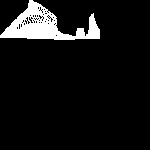

In [138]:
def create_floor_plan(points_2d, output_size=(150,150), scale=100):
    """
    Create a floor plan from 2D points.

    :param points_2d: numpy array of shape (N, 2)
    :param output_size: size of the output image
    :param scale: scale to fit points into the image
    :return: binary image representing the floor plan
    """
    # Normalize and scale points to fit in the image
    min_x, min_y = np.min(points_2d, axis=0)
    max_x, max_y = np.max(points_2d, axis=0)

    points_2d -= np.array([min_x, min_y])
    points_2d *= scale / max(max_x - min_x, max_y - min_y)

    img = np.zeros(output_size, dtype=np.uint8)

    for point in points_2d:
        x, y = point.astype(int)
        if 0 <= x < output_size[0] and 0 <= y < output_size[1]:
            img[y, x] = 255

    return img

# Create floor plan
floor_plan = create_floor_plan(floor_2d)
floor_plan

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
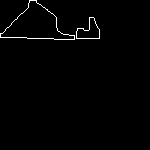

In [139]:
# Apply morphological operations to clean up the floor plan
kernel = np.ones((5, 5), np.uint8)
floor_plan = cv2.morphologyEx(floor_plan, cv2.MORPH_CLOSE, kernel)
floor_plan = cv2.morphologyEx(floor_plan, cv2.MORPH_OPEN, kernel)

# Optional: Find contours to draw walls or rooms
contours, _ = cv2.findContours(floor_plan, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
floor_plan_contours = np.zeros_like(floor_plan)
cv2.drawContours(floor_plan_contours, contours, -1, (255, 255, 255), 1)